In [39]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [36]:
# specify the kilosorted data directory
kilosort_dir = r"C:\Users\smearlab\clickbait-ephys\kilosorted_data\6002\5" 

# Parameters for building the spike rate matrix
fs = 30000 # Hz
window_size = 0.1 # seconds
step_size = 0.05 # seconds

In [78]:
def compute_spike_rates_sliding_window_by_region(kilosort_dir: str, sampling_rate: int, window_size: float =1.0, step_size: float = 0.5, use_units: str = 'all'):
    """
    Computes the spike rate for OB and HC units in sliding windows.

    Parameters:
    - kilosort_dir (str): Path to the Kilosort4 output directory.
    - sampling_rate (float): Sampling rate of the recording in Hz.
    - window_size (float): Size of the sliding window in seconds.
    - step_size (float): Step size between consecutive windows in seconds.
    - use_units (str): Specify which units to include ('all', 'good', 'mua').

    Returns:
    - spike_rate_matrix_OB (np.ndarray): 2D array (OB units x windows) of spike rates (Hz).
    - spike_rate_matrix_HC (np.ndarray): 2D array (HC units x windows) of spike rates (Hz).
    - time_bins (np.ndarray): Time points (seconds) corresponding to each window.
    - unit_ids_OB (np.ndarray): OB Unit IDs.
    - unit_ids_HC (np.ndarray): HC Unit IDs.
    """

    # Load spike times and cluster assignments
    spike_times_path = os.path.join(kilosort_dir, "spike_times.npy")
    spike_clusters_path = os.path.join(kilosort_dir, "spike_clusters.npy")
    templates_path = os.path.join(kilosort_dir, "templates.npy")
    templates_ind_path = os.path.join(kilosort_dir, "templates_ind.npy")
    cluster_groups_path = os.path.join(kilosort_dir, "cluster_group.tsv")

    # Ensure all required files exist
    if not all(os.path.exists(p) for p in [spike_times_path, spike_clusters_path, templates_path, templates_ind_path, cluster_groups_path]):
        raise FileNotFoundError("Missing required Kilosort output files.")

    # Loading the data
    templates = np.load(templates_path)  # Shape: (nTemplates, nTimePoints, nChannels)
    templates_ind = np.load(templates_ind_path)  # Shape: (nTemplates, nChannels)
    spike_times = np.load(spike_times_path) / sampling_rate  # Convert to seconds
    spike_clusters = np.load(spike_clusters_path)
    cluster_groups = np.loadtxt(cluster_groups_path, dtype=str, skiprows=1, usecols=[1])


    # Find peak amplitude channel for each template and assign to unit
    peak_channels = np.argmax(np.max(np.abs(templates), axis=1), axis=1)
    unit_best_channels = {unit: templates_ind[unit, peak_channels[unit]] for unit in range(len(peak_channels))}
    
    # Filter units based on use_units parameter
    if use_units == 'all':
        unit_best_channels = unit_best_channels
    elif use_units == 'good':
        unit_indices = np.where(cluster_groups == 'good')[0]
        unit_best_channels = {unit: unit_best_channels[unit] for unit in unit_indices}
    elif use_units == 'mua':
        unit_indices = np.where(cluster_groups == 'mua')[0]
        unit_best_channels = {unit: unit_best_channels[unit] for unit in unit_indices}
    elif use_units == 'good/mua':
        unit_indices = np.where(np.isin(cluster_groups, ['good', 'mua']))[0]
        unit_best_channels = {unit: unit_best_channels[unit] for unit in unit_indices}

    # Get total duration of the recording
    recording_duration = np.max(spike_times)

    # Define time windows
    time_bins = np.arange(0, recording_duration - window_size, step_size)
    num_windows = len(time_bins)

    # Separate OB and HC units
    ob_units = np.array([unit for unit, ch in unit_best_channels.items() if ch in range(0, 16)])
    hc_units = np.array([unit for unit, ch in unit_best_channels.items() if ch in range(16, 32)])
    num_ob_units = len(ob_units)
    num_hc_units = len(hc_units)

    # Initialize spike rate matrices
    spike_rate_matrix_OB = np.zeros((num_ob_units, num_windows))
    spike_rate_matrix_HC = np.zeros((num_hc_units, num_windows))

    # Compute spike counts in each window
    for i, t_start in tqdm(enumerate(time_bins), total=num_windows, desc="Computing spike rates"):
        t_end = t_start + window_size

        # Find spikes in this window
        in_window = (spike_times >= t_start) & (spike_times < t_end)
        spike_clusters_in_window = spike_clusters[in_window]

        # Compute spike rates for OB
        for j, unit in enumerate(ob_units):
            spike_rate_matrix_OB[j, i] = np.sum(spike_clusters_in_window == unit) / window_size  # Hz

        # Compute spike rates for HC
        for j, unit in enumerate(hc_units):
            spike_rate_matrix_HC[j, i] = np.sum(spike_clusters_in_window == unit) / window_size  # Hz

    return spike_rate_matrix_OB, spike_rate_matrix_HC, time_bins, ob_units, hc_units




In [79]:
rates_OB, rates_HC, time_bins, ob_units, hc_units = compute_spike_rates_sliding_window_by_region(kilosort_dir, fs, window_size, step_size, use_units='good')

Computing spike rates:   0%|          | 0/38737 [00:00<?, ?it/s]

Computing spike rates: 100%|██████████| 38737/38737 [02:05<00:00, 308.05it/s]


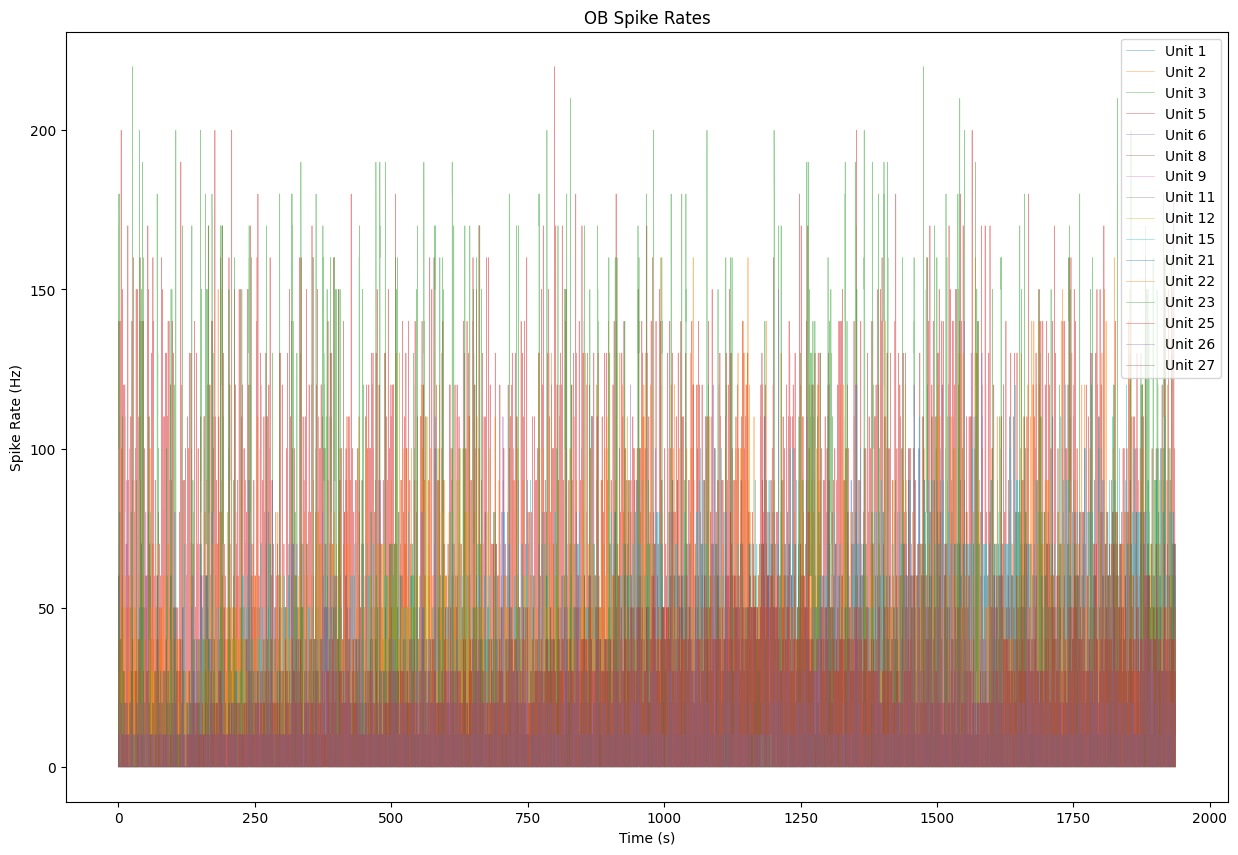

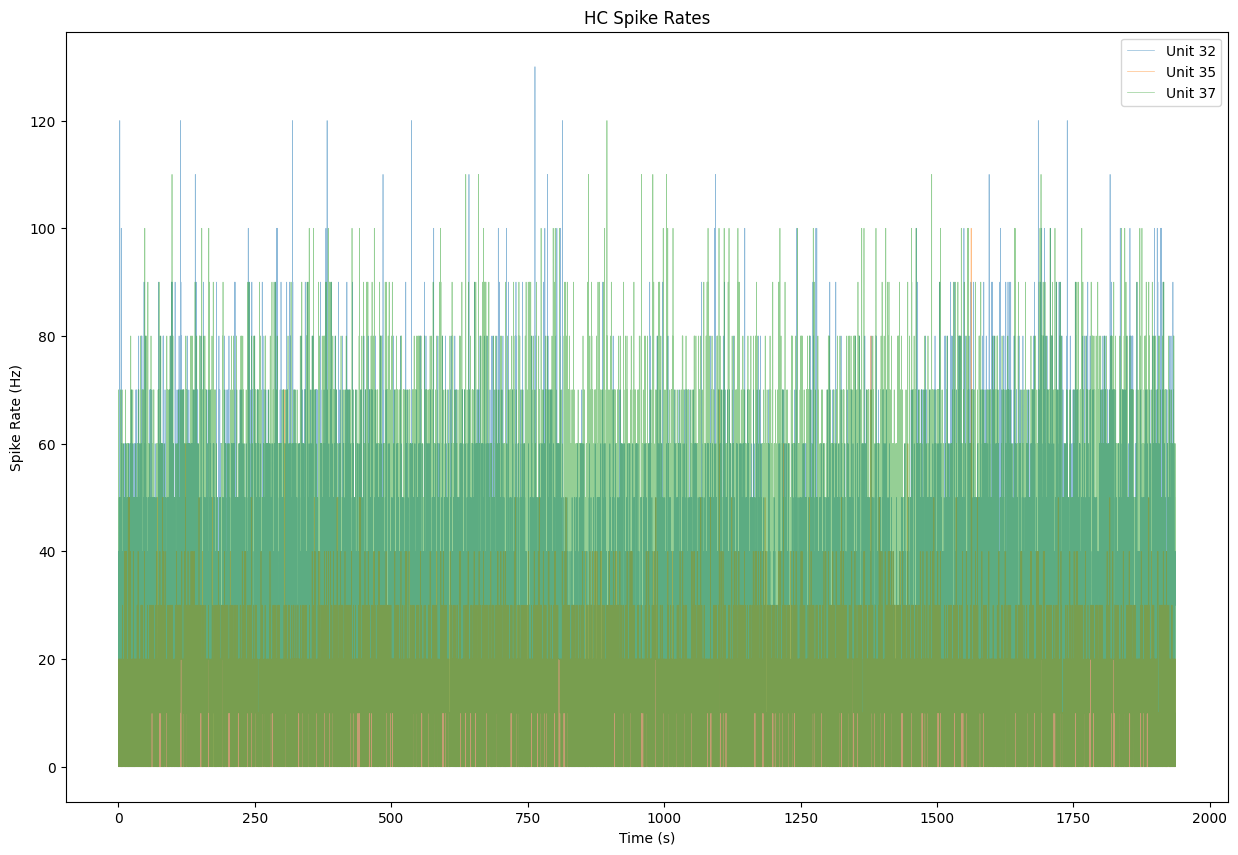

In [80]:
# Plotting the spike rates

for region in [("OB", rates_OB, ob_units), ("HC", rates_HC, hc_units)]:
    region_name, rates, units = region
    num_units = rates.shape[0]

    plt.figure(figsize=(15, 10))
    for i in range(num_units):
        plt.plot(time_bins, rates[i], label=f"Unit {units[i]}", alpha=0.5, linewidth=0.5)
    plt.title(f"{region_name} Spike Rates")
    plt.xlabel("Time (s)")
    plt.ylabel("Spike Rate (Hz)")
    plt.legend()
    plt.show()